In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 8
%matplotlib inline

In [2]:
pd.set_option('max_columns', None)
df_train = pd.read_csv('train_2.csv', low_memory=False, index_col='Unnamed: 0')
df_train.shape

(225000, 34)

In [3]:
df_train.head(3)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


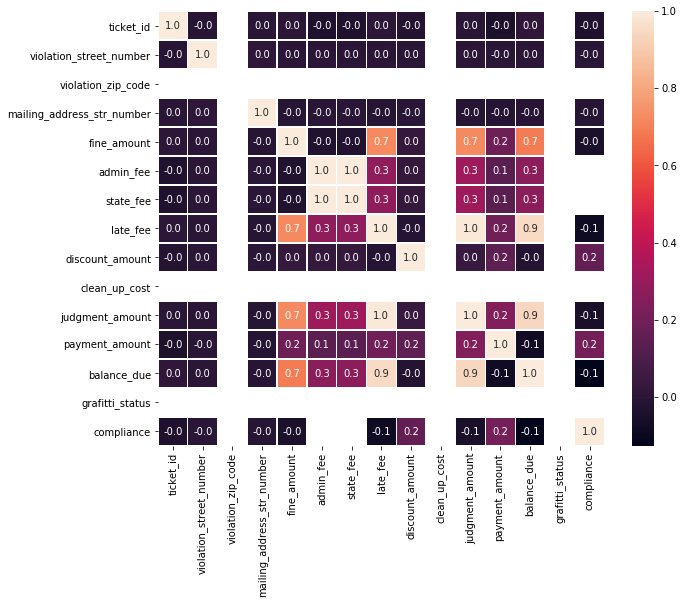

In [7]:
sns.heatmap(df_train.corr(), annot=True, fmt='.1f', linewidths='.3');

In [11]:
%%time
rows_with_missing = df_train[df_train['compliance'].isnull()].index

CPU times: user 56.5 ms, sys: 2.37 ms, total: 58.9 ms
Wall time: 77.4 ms


In [12]:
columns_drop = ['violation_zip_code', 'non_us_str_code', 'grafitti_status', 'compliance_detail', 
                'payment_amount', 'balance_due', 'payment_date', 'payment_status', 'collection_status']
df_train = df_train.drop(columns_drop, axis=1)
df_train = df_train.drop(rows_with_missing, axis=0)
df_train.shape

(144528, 25)

In [13]:
df_test = pd.read_csv('test_2.csv', index_col='Unnamed: 0')
df_test = df_test.drop(['violation_zip_code', 'non_us_str_code', 'grafitti_status'], axis=1)
df_test.shape

(25305, 24)

In [14]:
passes_num = ['mailing_address_str_number', 'zip_code', 'fine_amount']
passes_cat = ['violator_name', 'mailing_address_str_name', 'state']
passes_date = ['hearing_date']

In [15]:
df_train[passes_num] = df_train[passes_num].fillna(method='ffill')
df_train[passes_cat] = df_train[passes_cat].fillna(method='ffill')
df_train[passes_date] = df_train[passes_date].fillna(method='ffill')

In [35]:
num_variables = ['ticket_id', 'violation_street_number', 'mailing_address_str_number', 'fine_amount',
                 'discount_amount']
len(num_variables)

5

In [36]:
y = df_train['compliance']
X = df_train[num_variables]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144528 entries, 0 to 224999
Data columns (total 5 columns):
ticket_id                     144528 non-null int64
violation_street_number       144528 non-null float64
mailing_address_str_number    144528 non-null float64
fine_amount                   144528 non-null float64
discount_amount               144528 non-null float64
dtypes: float64(4), int64(1)
memory usage: 6.6 MB


In [37]:
X.head()

,ticket_id,violation_street_number,mailing_address_str_number,fine_amount,discount_amount
0,22056,2900.0,3.0,250.0,0.0
1,27586,4311.0,2959.0,750.0,0.0
5,22046,6478.0,2755.0,250.0,0.0
6,18738,8027.0,476.0,750.0,0.0
7,18735,8228.0,8228.0,100.0,0.0


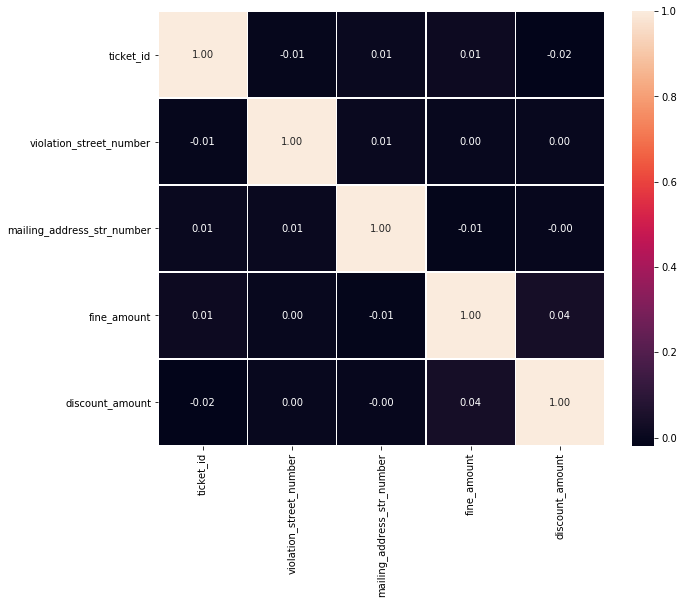

In [39]:
sns.heatmap(X.corr(), annot=True, fmt='.2f', linewidths='.3');

In [26]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(X.columns):
    plt.subplot(4, 3, i + 1)
    plt.scatter(X[col], y)
    plt.title(col);

In [21]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [42]:
%%time
arr = []
for i in [500]:
    gbm_model = GradientBoostingClassifier(n_estimators=i, random_state=42)
    gbm_model.fit(X, y)
    score = cross_val_score(gbm_model, X, y, cv=kfold, scoring='roc_auc')
    arr.append(score.mean())

CPU times: user 5min 23s, sys: 464 ms, total: 5min 23s
Wall time: 5min 25s


In [74]:
arr_df = pd.DataFrame(arr, [500])
arr_df.max()

0    0.705441
dtype: float64

In [49]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [66]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_params = {'max_features': [1, 2, 4], 
             'min_samples_leaf': [7, 9], 
             'max_depth': [15, 20]}

In [67]:
%%time
grid_rf = GridSearchCV(rf_model, rf_params, cv=skf, n_jobs=-1)
grid_rf.fit(X, y)

CPU times: user 1min 6s, sys: 252 ms, total: 1min 6s
Wall time: 20min 29s


In [68]:
grid_rf.best_params_

{'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 7}

In [72]:
%%time
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, 
                                  max_features=4, min_samples_leaf=7, random_state=42)
score = np.mean(cross_val_score(rf_model, X, y, cv=skf, scoring='roc_auc'))

CPU times: user 4min 17s, sys: 248 ms, total: 4min 18s
Wall time: 4min 19s


In [73]:
score

0.7333600342888673